# Liquid Loading Prediction using Turner Equation
**Author:** Ade Anggi Naluriawan Santoso | **Project:** Production Data Analysis (RTA/DCA)

## 1. Introduction
This notebook demonstrates how to predict liquid loading in gas wells using production data. We will utilize the **Turner (1969)** droplet model, which is the most widely used empirical correlation for determining the minimum gas velocity required to lift liquids in vertical tubing.

**Objective:** Flag days where the well is unable to lift liquids (Liquid Loading).

## 2. Theory & Equations

### The Turner Equation
The critical velocity ($v_c$) is calculated as:

$$v_c (ft/s) = 1.593 \frac{\sigma^{0.25} (\rho_L - \rho_g)^{0.25}}{\rho_g^{0.5}}$$

### Gas Density ($\rho_g$)
To solve Turner, we first need the in-situ gas density. Using real gas laws:

$$\rho_g = \frac{2.7 \times S.G. \times P}{Z \times T}$$

Where:
* $P$ = Pressure (psia)
* $T$ = Temperature (Rankine)
* $Z$ = Gas Compressibility Factor (assumed 0.9 for this demo)
* $S.G.$ = Gas Specific Gravity (assumed 0.65 for typical natural gas)

### Actual Gas Velocity ($v_{actual}$)
We compare $v_c$ against the actual velocity of the gas in the tubing:

$$v_{actual} = \frac{4.71 \times 10^{-2} \times Q_{Mscfd} \times T_{Rankine} \times Z}{P_{psia} \times D_{inch}^2}$$

Where:
* $Q$ = Gas Rate (Mscfd)
* $D$ = Tubing Internal Diameter (inches)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set plotting style
plt.style.use('seaborn-v0_8')

## 3. Data Loading
We load the daily production records. The dataset includes tubing pressure, temperature, and gas flow rates.

In [2]:
# Load the dataset
df = pd.read_csv('production_data.csv')

# Convert Date to datetime object
df['Date'] = pd.to_datetime(df['Date'])

# Preview the data
df.head()

,Date,Well_ID,Tubing_Pressure_psi,Temperature_F,Gas_Rate_Mscfd,Tubing_ID_inch,Liquid_Density_lb_ft3,Surface_Tension_dynes_cm
0,2023-10-01,Well-001,500,150,2500,2.441,67.0,60
1,2023-10-02,Well-001,495,148,2450,2.441,67.0,60
2,2023-10-03,Well-001,490,148,2300,2.441,67.0,60
3,2023-10-04,Well-001,480,145,2100,2.441,67.0,60
4,2023-10-05,Well-001,450,142,1800,2.441,67.0,60


## 4. Feature Engineering: Physics Calculations

We need to convert units and calculate the physical properties of the gas to apply the Turner equation.

**Assumptions for this Calculation:**
* **Gas Specific Gravity (SG):** 0.65 (Typical Natural Gas)
* **Z-Factor:** 0.9 (Simplified constant; in production, use Dranchuk-Abou-Kassem correlation)
* **Pressure:** Convert Gauge (psig) to Absolute (psia) by adding 14.7.
* **Temperature:** Convert Fahrenheit to Rankine ($F + 460$).

In [3]:
# Constants
GAS_SG = 0.65
Z_FACTOR = 0.9

# 1. Unit Conversions
# Convert Pressure to Absolute (psia) and Temperature to Rankine
df['Pressure_psia'] = df['Tubing_Pressure_psi'] + 14.7
df['Temp_Rankine'] = df['Temperature_F'] + 460.67

# 2. Calculate Gas Density (rho_g) - lb/ft3
# Formula: (2.7 * SG * P) / (Z * T)
df['Gas_Density'] = (2.7 * GAS_SG * df['Pressure_psia']) / (Z_FACTOR * df['Temp_Rankine'])

# 3. Calculate Critical Velocity (Turner) - ft/s
# Formula: 1.593 * (sigma^0.25 * (rho_L - rho_g)^0.25) / rho_g^0.5
numerator = (df['Surface_Tension_dynes_cm']**0.25) * ((df['Liquid_Density_lb_ft3'] - df['Gas_Density'])**0.25)
denominator = df['Gas_Density']**0.5
df['Critical_Velocity'] = 1.593 * (numerator / denominator)

# 4. Calculate Actual Gas Velocity (Corrected) - ft/s
# Formula derived from Real Gas Law: v = (0.06 * Q * T * Z) / (P * D^2)
# Constant 0.06 accounts for units: Q in Mscfd, P in psia, T in R, D in inches
numerator_v = 0.06 * df['Gas_Rate_Mscfd'] * df['Temp_Rankine'] * Z_FACTOR
denominator_v = df['Pressure_psia'] * (df['Tubing_ID_inch']**2)
df['Actual_Velocity'] = numerator_v / denominator_v

# Display calculation results to verify magnitudes
# Actual Velocity should now start around ~25-28 ft/s for 2500 Mscfd
df[['Date', 'Gas_Rate_Mscfd', 'Gas_Density', 'Critical_Velocity', 'Actual_Velocity']].head()

,Date,Gas_Rate_Mscfd,Gas_Density,Critical_Velocity,Actual_Velocity
0,2023-10-01,2500,1.643547,9.832968,26.881322
1,2023-10-02,2450,1.632929,9.865286,26.514995
2,2023-10-03,2300,1.616911,9.914640,25.138226
3,2023-10-04,2100,1.592724,9.990561,23.300844
4,2023-10-05,1800,1.503584,10.285943,21.156197


## 4.1. Comparison Method: Coleman (1991)
While Turner is the industry standard, it includes a ~20% empirical adjustment factor (safety margin) added to the theoretical derivation.

**Coleman (1991)** argued that for wells with lower reservoir pressures (typically < 500 psi), this 20% adjustment is unnecessary and often too conservative (i.e., it predicts the well will die sooner than it actually does).

The Coleman equation uses the same variables but removes the safety margin, changing the constant from **1.593** to **1.328**.

$$v_{c, Coleman} = 1.328 \frac{\sigma^{0.25} (\rho_L - \rho_g)^{0.25}}{\rho_g^{0.5}}$$

In [6]:
# Calculate Critical Velocity (Coleman Method)
# We use the same numerator/denominator parts but scale by 1.328 instead of 1.593
# Note: 1.593 / 1.2 (20% margin) ≈ 1.328

df['Coleman_Velocity'] = 1.328 * (numerator / denominator)

# Compare the two critical velocities
df[['Date', 'Critical_Velocity', 'Coleman_Velocity', 'Actual_Velocity']].head()

,Date,Critical_Velocity,Coleman_Velocity,Actual_Velocity
0,2023-10-01,9.832968,8.197226,26.881322
1,2023-10-02,9.865286,8.224168,26.514995
2,2023-10-03,9.914640,8.265312,25.138226
3,2023-10-04,9.990561,8.328603,23.300844
4,2023-10-05,10.285943,8.574848,21.156197


## 5. Risk Assessment (Flagging)
We compare the Actual Velocity against the Critical Velocity.

* If **Actual Velocity < Critical Velocity**: The gas is too slow to lift the liquid. **Risk = 1 (High)**.
* If **Actual Velocity > Critical Velocity**: The well is flowing stably. **Risk = 0 (Low)**.

In [4]:
# Create the binary flag
df['Liquid_Loading_Risk'] = np.where(df['Actual_Velocity'] < df['Critical_Velocity'], 'High Risk', 'Stable')

# Filter to see only High Risk days
high_risk_days = df[df['Liquid_Loading_Risk'] == 'High Risk']
high_risk_days[['Date', 'Actual_Velocity', 'Critical_Velocity', 'Liquid_Loading_Risk']]

,Date,Actual_Velocity,Critical_Velocity,Liquid_Loading_Risk
7,2023-10-08,10.389503,11.176489,High Risk
8,2023-10-09,8.348956,11.201818,High Risk
9,2023-10-10,7.727735,11.256750,High Risk


## 6. Visualization
Visualizing the "Velocity Cross-over" is the standard way to present this analysis to production engineers. When the *Actual Velocity* line crosses below the *Critical Velocity* line, the well has loaded up.

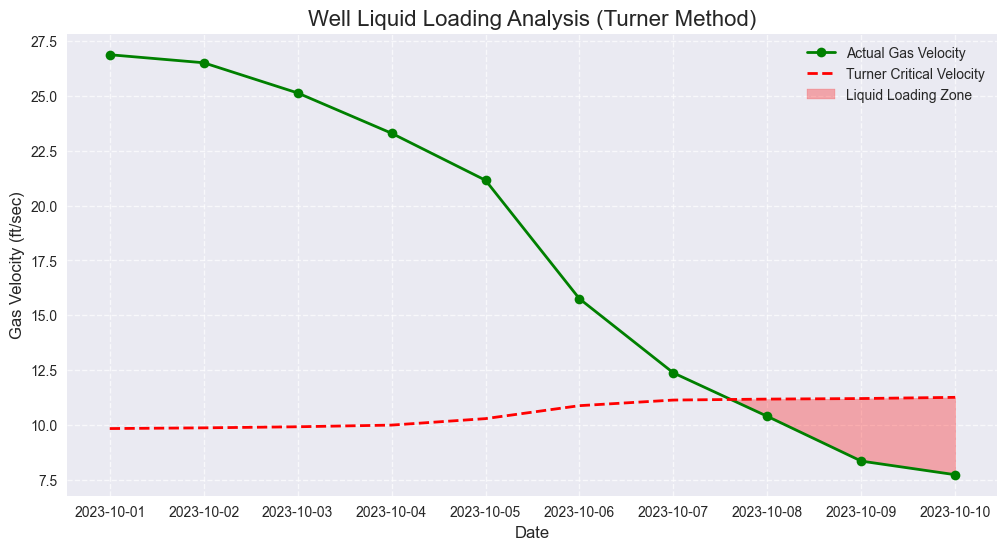

In [5]:
fig, ax = plt.subplots(figsize=(12, 6))

# Plot Critical vs Actual Velocity
ax.plot(df['Date'], df['Actual_Velocity'], label='Actual Gas Velocity', marker='o', color='green', linewidth=2)
ax.plot(df['Date'], df['Critical_Velocity'], label='Turner Critical Velocity', linestyle='--', color='red', linewidth=2)

# Fill area to highlight risk
ax.fill_between(df['Date'], df['Actual_Velocity'], df['Critical_Velocity'], 
                where=(df['Actual_Velocity'] < df['Critical_Velocity']), 
                interpolate=True, color='red', alpha=0.3, label='Liquid Loading Zone')

# Formatting
ax.set_title('Well Liquid Loading Analysis (Turner Method)', fontsize=16)
ax.set_ylabel('Gas Velocity (ft/sec)', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)

plt.show()

## 7. Conclusion
In this analysis, we successfully identified the onset of liquid loading.
* **Result:** The well entered the "Liquid Loading Zone" starting on **2023-10-07**, where the actual gas velocity dropped below the critical velocity required to lift water.
* **Action Item:** This flag would trigger a recommendation for velocity string installation, surfactant injection, or plunger lift deployment.

# 8. Comparative Plotting

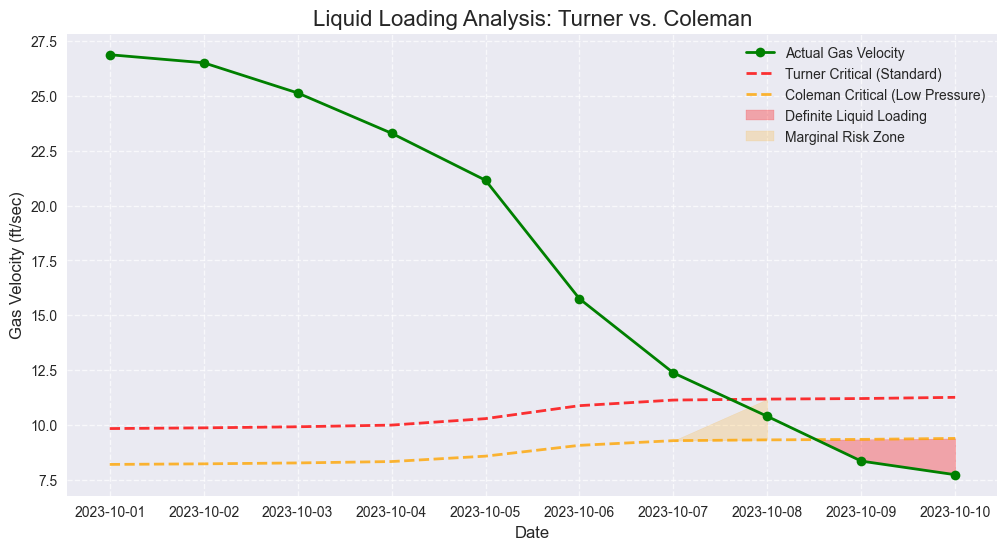

In [7]:
fig, ax = plt.subplots(figsize=(12, 6))

# 1. Plot Actual Gas Velocity
ax.plot(df['Date'], df['Actual_Velocity'], label='Actual Gas Velocity', 
        marker='o', color='green', linewidth=2, zorder=3)

# 2. Plot Turner Critical Velocity (Conservative)
ax.plot(df['Date'], df['Critical_Velocity'], label='Turner Critical (Standard)', 
        linestyle='--', color='red', linewidth=2, alpha=0.8)

# 3. Plot Coleman Critical Velocity (Optimistic)
ax.plot(df['Date'], df['Coleman_Velocity'], label='Coleman Critical (Low Pressure)', 
        linestyle='--', color='orange', linewidth=2, alpha=0.8)

# 4. Fill areas to show different risk zones
# Zone A: Definite Loading (Below both lines)
ax.fill_between(df['Date'], df['Actual_Velocity'], df['Coleman_Velocity'], 
                where=(df['Actual_Velocity'] < df['Coleman_Velocity']), 
                interpolate=True, color='red', alpha=0.3, label='Definite Liquid Loading')

# Zone B: Marginal/Uncertain (Between Coleman and Turner)
# This represents the "Safety Margin" buffer
ax.fill_between(df['Date'], df['Coleman_Velocity'], df['Critical_Velocity'], 
                where=((df['Actual_Velocity'] < df['Critical_Velocity']) & (df['Actual_Velocity'] > df['Coleman_Velocity'])), 
                interpolate=True, color='orange', alpha=0.2, label='Marginal Risk Zone')

# Formatting
ax.set_title('Liquid Loading Analysis: Turner vs. Coleman', fontsize=16)
ax.set_ylabel('Gas Velocity (ft/sec)', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.legend(loc='upper right')
ax.grid(True, linestyle='--', alpha=0.7)

plt.show()